In [2]:
import pandas as pd
import matplotlib.pyplot as plt  
from statsmodels.tsa.seasonal import seasonal_decompose


In [3]:
df_s = pd.read_csv('/Users/mstee/Documents/School/projectwork/data/smhi_temp_data_save.csv', usecols=[0, 1, 2, 3], header=6, sep=';')
df_g = pd.read_csv('/Users/mstee/Documents/School/projectwork/data/avg_daily_temp_curated.csv')

In [27]:
df_s
df_g

,Datum,Kvalitet,Snittemperatur,Month
0,1961-01-01,G,1.07,1961-01
1,1961-01-02,G,2.27,1961-01
2,1961-01-03,G,2.27,1961-01
3,1961-01-04,G,2.53,1961-01
4,1961-01-05,G,2.13,1961-01
...,...,...,...,...
19909,2023-06-27,G,18.18,2023-06
19910,2023-06-28,G,19.72,2023-06
19911,2023-06-29,G,19.22,2023-06
19912,2023-06-30,G,17.40,2023-06


Change to monthly temp 

In [7]:
# Assuming your DataFrame is called df_s
# Convert the "Datum" column to a datetime object
df_s['Datum'] = pd.to_datetime(df_s['Datum'], format = '')

# Group the data by date and calculate the daily mean temperature
df_s = df_s.groupby('Datum')['Lufttemperatur'].mean().reset_index()

# # Rename the columns in the new DataFrame
df_s = df_s.rename(columns={'Datum': 'Datum', 'Lufttemperatur': 'Snittemperatur'})

# # Print the resulting DataFrame
# print(daily_temp)
df_s

,Datum,Snittemperatur
0,1944-01-01,3.200000
1,1944-01-02,3.600000
2,1944-01-03,2.800000
3,1944-01-04,-4.466667
4,1944-01-05,-1.400000
...,...,...
22980,2006-12-01,8.033333
22981,2006-12-02,8.808333
22982,2006-12-03,8.112500
22983,2006-12-04,8.566667


Change variable types 

In [8]:
print(df_s.dtypes)

Datum             datetime64[ns]
Snittemperatur           float64
dtype: object


EDA 

In [9]:
print(df_s['Snittemperatur'].describe())

count    22985.000000
mean         7.481754
std          7.437469
min        -21.704167
25%          1.973913
50%          7.437500
75%         13.779167
max         28.600000
Name: Snittemperatur, dtype: float64


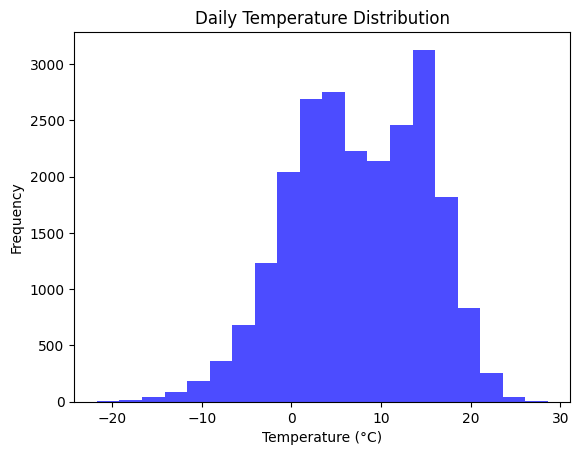

In [10]:


temperature_data = df_s['Snittemperatur']

# Create a histogram
plt.hist(temperature_data, bins=20, color='blue', alpha=0.7)
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.title('Daily Temperature Distribution')

plt.show()

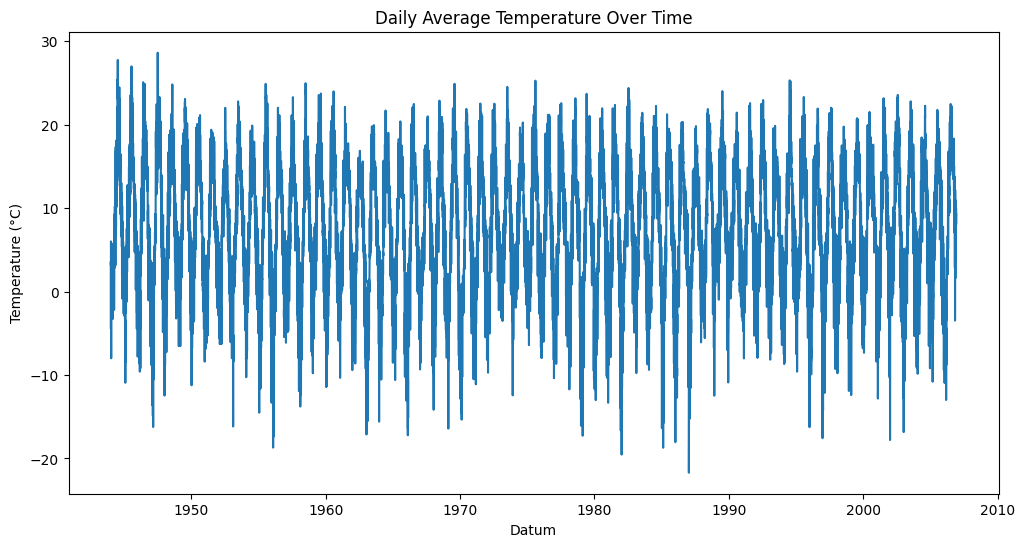

In [11]:

plt.figure(figsize=(12, 6))
plt.plot(df_s['Datum'], df_s['Snittemperatur'])
plt.xlabel('Datum')
plt.ylabel('Temperature (°C)')
plt.title('Daily Average Temperature Over Time')
plt.show()

attempt to insert in gotheburg in the missing save data, dates after 2006-12-06

In [24]:
noentries_subset = df_s[(df_s['Datum'] >= '2006-12-06') & (df_s['Datum'] <= '2008-12-31')]

len(noentries_subset)
noentries_subset

,Datum,Snittemperatur


In [29]:
columns_to_drop = ['Month', 'Kvalitet']
df_g = df_g.drop(columns=columns_to_drop)

In [33]:


# Make sure the "Datum" column in both dataframes is of datetime type
df_s['Datum'] = pd.to_datetime(df_s['Datum'])
df_g['Datum'] = pd.to_datetime(df_g['Datum'])

# Filter the rows from df_sav that match your date criteria
filtered_df_g = df_g[(df_g['Datum'] >= '2006-12-06')]
# filtered_df_sav_2 = df_sav[]
# Now, you can concatenate the filtered_df_g with df_s
df_s = pd.concat([df_s, filtered_df_g], ignore_index=True)

# Sort the resulting dataframe by the "Datum" column
df_s = df_s.sort_values(by='Datum')

# Reset the index
df_s = df_s.reset_index(drop=True)


In [34]:
df_s

,Datum,Snittemperatur
0,1944-01-01,3.200000
1,1944-01-02,3.600000
2,1944-01-03,2.800000
3,1944-01-04,-4.466667
4,1944-01-05,-1.400000
...,...,...
35024,2023-06-29,19.220000
35025,2023-06-30,17.400000
35026,2023-06-30,17.400000
35027,2023-07-01,16.060000


Time series analysis 

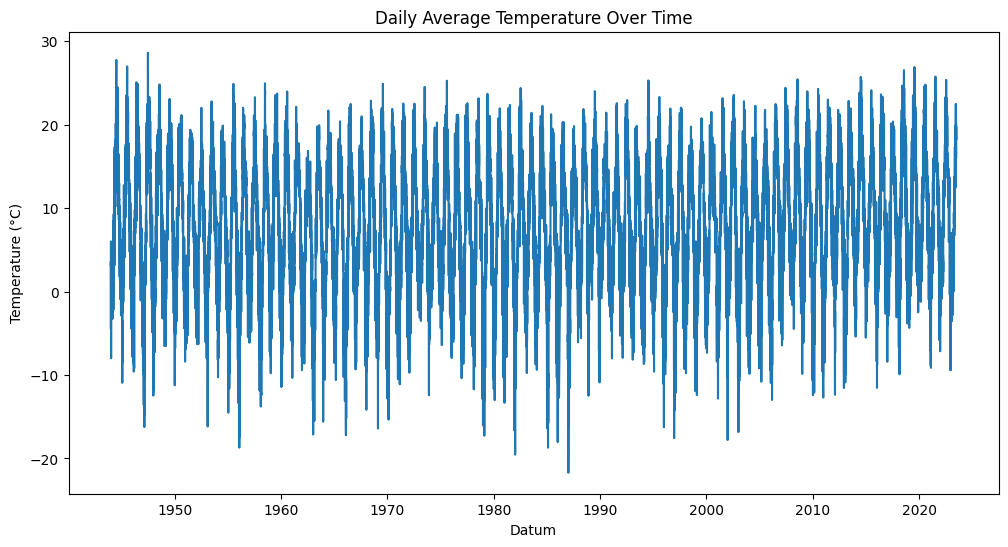

In [35]:

plt.figure(figsize=(12, 6))
plt.plot(df_s['Datum'], df_s['Snittemperatur'])
plt.xlabel('Datum')
plt.ylabel('Temperature (°C)')
plt.title('Daily Average Temperature Over Time')
plt.show()

In [36]:
decomposition = seasonal_decompose(df_s['Snittemperatur'], model='additive')
trend = decomposition.trend
# seasonal = decomposition.seasonal
# residual = decomposition.resid

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [38]:
# export the filled out save data set with just temp

df_s.to_csv('/Users/mstee/Documents/School/projectwork/data/Mike1310_save_averagetemp_with_GBGdata.csv', index = False)